In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data_m1 = pd.read_excel('data/M2.xlsx')

# Features (X) and target (y)
X_m1 = data_m1.drop('WPR', axis=1)
y_m1 = data_m1['WPR']

# Show the first 20 rows of the data
print(data_m1.head(20))

# Split data into training and testing sets
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)

print("X_train_m1 shape:", X_train_m1.shape)
print("y_train_m1 shape:", y_train_m1.shape)


     effa   effc   effd      mu     T20       win    COP       WPR
0   0.000  0.000  0.000  0.0000   0.000  0.002411  0.000  0.000000
1   0.000  0.000  0.000  0.0000   0.000  0.002006  0.000  0.000000
2   0.000  0.000  0.000  0.0000   0.000  0.002001  0.000  0.000000
3   0.000  0.000  0.000  0.0000   0.000  0.002102  0.000  0.000000
4   0.000  0.000  0.000  0.0000   0.000  0.002078  0.000  0.000000
5   0.000  0.000  0.000  0.0000   0.000  0.002011  0.000  0.000000
6   0.000  0.000  0.000  0.0000   0.000  0.001874  0.000  0.000000
7   0.000  0.000  0.000  0.0000   0.000  0.001938  0.000  0.000000
8   0.689  0.641  0.497  0.1590  -6.700  0.002231  0.698  0.100440
9   0.666  0.641  0.478  0.2288 -13.250  0.002167  0.771  1.051920
10  0.653  0.641  0.469  0.2544 -16.520  0.002276  0.777  1.505088
11  0.648  0.641  0.465  0.2702 -16.210  0.002703  0.777  1.938276
12  0.645  0.641  0.462  0.2800 -16.050  0.003149  0.776  2.405268
13  0.649  0.641  0.465  0.2815 -13.430  0.003044  0.777  2.01

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_m1_scaled = scaler.fit_transform(X_train_m1)
X_test_m1_scaled = scaler.transform(X_test_m1)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can choose 'median', 'most_frequent', or 'constant'
X_train_m1_scaled = imputer.fit_transform(X_train_m1_scaled)
X_test_m1_scaled = imputer.transform(X_test_m1_scaled)

# Reshape the input to be 3D [samples, timesteps, features]
X_train_m1_lstm = np.reshape(X_train_m1_scaled, (X_train_m1_scaled.shape[0], 1, X_train_m1_scaled.shape[1]))
X_test_m1_lstm = np.reshape(X_test_m1_scaled, (X_test_m1_scaled.shape[0], 1, X_test_m1_scaled.shape[1]))

print("X_train_m1_lstm shape:", X_train_m1_lstm.shape)
print("X_test_m1_lstm shape:", X_test_m1_lstm.shape)


2024-09-02 16:53:16.653662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 16:53:16.922765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 16:53:16.925244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 16:53:20.453874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_train_m1_lstm shape: (7008, 1, 7)
X_test_m1_lstm shape: (1752, 1, 7)


In [3]:
import numpy as np

print(np.isnan(X_test_m1_lstm).sum())  # Count NaNs in training features
print(np.isnan(X_test_m1_lstm).sum())   # Count NaNs in testing features
print(np.isnan(y_train_m1).sum())  # Count NaNs in training labels
print(np.isnan(y_test_m1).sum())   # Count NaNs in testing labels


0
0
0
0


In [4]:
# Build the baseline LSTM model

# Define the baseline LSTM model
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_m1_lstm.shape[1], X_train_m1_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

baseline_lstm_model = create_lstm_model()


# Train the baseline LSTM model
baseline_lstm_model.fit(X_train_m1_lstm, y_train_m1, epochs=20, batch_size=32, validation_data=(X_test_m1_lstm, y_test_m1), verbose=1)

# Predict on the training and test data
y_train_pred_lstm_baseline = baseline_lstm_model.predict(X_train_m1_lstm)
y_test_pred_lstm_baseline = baseline_lstm_model.predict(X_test_m1_lstm)

# Save predictions vs. ground truth to Excel
baseline_lstm_train_results = pd.DataFrame({'Ground Truth': y_train_m1, 'Prediction': y_train_pred_lstm_baseline.flatten()})
baseline_lstm_test_results = pd.DataFrame({'Ground Truth': y_test_m1, 'Prediction': y_test_pred_lstm_baseline.flatten()})

baseline_lstm_train_results.to_excel('outputs/M2baseline_lstm_train_predictions.xlsx', index=False)
baseline_lstm_test_results.to_excel('outputs/M2baseline_lstm_test_predictions.xlsx', index=False)


2024-09-02 16:53:24.869825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
219/219 [==============================] - 22s 32ms/step - loss: 0.9121 - val_loss: 0.7287
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.7901 - val_loss: 0.6417
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.6537 - val_loss: 0.5572
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.5796 - val_loss: 0.5154
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.5586 - val_loss: 0.5124
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.5496 - val_loss: 0.5071
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.5349 - val_loss: 0.4878
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.5233 - val_loss: 0.4760
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.5196 - val_loss: 0.4732
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.5182 - val_l

In [5]:
print(X_train_m1_lstm.shape)
print(X_train_m1.shape)


(7008, 1, 7)
(7008, 7)


In [6]:
from pyswarm import pso  # This is a placeholder, replace with actual PSO implementation

# Define the fitness function for LSTM model
def lstm_fitness_function(params):
    # Unpack parameters
    lstm_units = int(params[0])
    dropout_rate = params[1]
    learning_rate = params[2]
    batch_size = int(params[3])
    
    # Build the LSTM model with the parameters
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(1, 7)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    
    
    # Train the model
    model.fit(X_train_m1_lstm, y_train_m1, epochs=10, batch_size=batch_size, verbose=0)
    
    # Evaluate on validation set
    y_pred = model.predict(X_test_m1_lstm)
    mse = mean_squared_error(y_test_m1, y_pred)
    
    return mse

# Set the bounds for parameters: [lstm_units, dropout_rate, learning_rate, batch_size]
bounds = ([10, 0.1, 0.0001, 16], [100, 0.5, 0.01, 128])

# Run the PSO
best_params, best_mse = pso(lstm_fitness_function, bounds[0], bounds[1], swarmsize=20, maxiter=10)

print(f'Optimized Parameters (PSO): lstm_units = {int(best_params[0])}, dropout_rate = {best_params[1]}, learning_rate = {best_params[2]}, batch_size = {int(best_params[3])}')
print(f'Best MSE achieved: {best_mse}')


55/55 [==============================] - 3s 4ms/step
Stopping search: maximum iterations reached --> 10
Optimized Parameters (PSO): lstm_units = 71, dropout_rate = 0.11513715956089554, learning_rate = 0.006586013981843674, batch_size = 16
Best MSE achieved: 0.37178456609366867


In [7]:
# Train the LSTM model with the optimized parameters
optimized_lstm_model = Sequential()
optimized_lstm_model.add(LSTM(units=int(best_params[0]), return_sequences=True, input_shape=(X_train_m1_lstm.shape[1], X_train_m1_lstm.shape[2])))
optimized_lstm_model.add(Dropout(best_params[1]))
optimized_lstm_model.add(LSTM(units=int(best_params[0])))
optimized_lstm_model.add(Dropout(best_params[1]))
optimized_lstm_model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params[2])
optimized_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the optimized model
optimized_lstm_model.fit(X_train_m1_lstm, y_train_m1, epochs=20, batch_size=int(best_params[3]), verbose=1)

# Make predictions
y_train_pred_lstm_optimized = optimized_lstm_model.predict(X_train_m1_lstm)
y_test_pred_lstm_optimized = optimized_lstm_model.predict(X_test_m1_lstm)

# Save predictions vs. ground truth to Excel
optimized_lstm_train_results = pd.DataFrame({'Ground Truth': y_train_m1, 'Prediction': y_train_pred_lstm_optimized.flatten()})
optimized_lstm_test_results = pd.DataFrame({'Ground Truth': y_test_m1, 'Prediction': y_test_pred_lstm_optimized.flatten()})

optimized_lstm_train_results.to_excel('outputs/M2optimized_lstm_train_predictions_PSO.xlsx', index=False)
optimized_lstm_test_results.to_excel('outputs/M2optimized_lstm_test_predictions_PSO.xlsx', index=False)


Epoch 1/20
438/438 [==============================] - 23s 29ms/step - loss: 0.7247
Epoch 2/20
438/438 [==============================] - 13s 31ms/step - loss: 0.5477
Epoch 3/20
438/438 [==============================] - 12s 27ms/step - loss: 0.5255
Epoch 4/20
438/438 [==============================] - 10s 22ms/step - loss: 0.5102
Epoch 5/20
438/438 [==============================] - 7s 16ms/step - loss: 0.4960
Epoch 6/20
438/438 [==============================] - 5s 11ms/step - loss: 0.4945
Epoch 7/20
438/438 [==============================] - 4s 9ms/step - loss: 0.4850
Epoch 8/20
438/438 [==============================] - 6s 14ms/step - loss: 0.4663
Epoch 9/20
438/438 [==============================] - 5s 12ms/step - loss: 0.4696
Epoch 10/20
438/438 [==============================] - 4s 8ms/step - loss: 0.4614
Epoch 11/20
438/438 [==============================] - 3s 8ms/step - loss: 0.4581
Epoch 12/20
438/438 [==============================] - 4s 8ms/step - loss: 0.4532
Epoch 13/20
4

55/55 [==============================] - 1s 4ms/step
 The best solution found:                                                                           
 [5.42172689e+01 1.25043518e-01 6.41399247e-03 3.08938159e+01]

 Objective function:
 0.3811447752328437


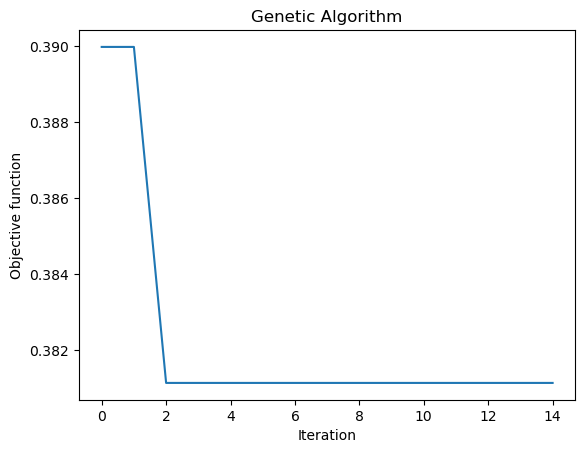

In [8]:
from geneticalgorithm import geneticalgorithm as ga

# Define the fitness function for LSTM model
def lstm_fitness_function_ga(params):
    lstm_units = int(params[0])
    dropout_rate = params[1]
    learning_rate = params[2]
    batch_size = int(params[3])

    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train_m1_lstm.shape[1], X_train_m1_lstm.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.fit(X_train_m1_lstm, y_train_m1, epochs=10, batch_size=batch_size, verbose=0)
    
    y_pred = model.predict(X_test_m1_lstm)
    mse = mean_squared_error(y_test_m1, y_pred)
    
    return mse

# Set the bounds for GA: [lstm_units, dropout_rate, learning_rate, batch_size]
varbound = np.array([[10, 100], [0.1, 0.5], [0.0001, 0.01], [16, 128]])

algorithm_param = {'max_num_iteration': 50, 'population_size': 20, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type':'uniform', 'max_iteration_without_improv':10}

model = model = ga(function=lstm_fitness_function_ga, 
           dimension=4, 
           variable_type='real', 
           variable_boundaries=varbound, 
           algorithm_parameters=algorithm_param,
           function_timeout=300)  # Increase the timeout

model.run()

best_params_ga = model.output_dict['variable']

print(f'Optimized Parameters (GA): lstm_units = {int(best_params_ga[0])}, dropout_rate = {best_params_ga[1]}, learning_rate = {best_params_ga[2]}, batch_size = {int(best_params_ga[3])}')


In [9]:
# Train the LSTM model with the GA-optimized parameters
optimized_lstm_model_ga = Sequential()
optimized_lstm_model_ga.add(LSTM(units=int(best_params_ga[0]), return_sequences=True, input_shape=(X_train_m1_lstm.shape[1], X_train_m1_lstm.shape[2])))
optimized_lstm_model_ga.add(Dropout(best_params_ga[1]))
optimized_lstm_model_ga.add(LSTM(units=int(best_params_ga[0])))
optimized_lstm_model_ga.add(Dropout(best_params_ga[1]))
optimized_lstm_model_ga.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params_ga[2])
optimized_lstm_model_ga.compile(optimizer=optimizer, loss='mean_squared_error')

optimized_lstm_model_ga.fit(X_train_m1_lstm, y_train_m1, epochs=20, batch_size=int(best_params_ga[3]), verbose=1)

# Make predictions
y_train_pred_lstm_ga = optimized_lstm_model_ga.predict(X_train_m1_lstm)
y_test_pred_lstm_ga = optimized_lstm_model_ga.predict(X_test_m1_lstm)

# Save predictions vs. ground truth to Excel
optimized_lstm_train_results_ga = pd.DataFrame({'Ground Truth': y_train_m1, 'Prediction': y_train_pred_lstm_ga.flatten()})
optimized_lstm_test_results_ga = pd.DataFrame({'Ground Truth': y_test_m1, 'Prediction': y_test_pred_lstm_ga.flatten()})

optimized_lstm_train_results_ga.to_excel('outputs/M2optimized_lstm_train_predictions_ga.xlsx', index=False)
optimized_lstm_test_results_ga.to_excel('outputs/M2optimized_lstm_test_predictions_ga.xlsx', index=False)


Epoch 1/20
234/234 [==============================] - 10s 8ms/step - loss: 0.7820
Epoch 2/20
234/234 [==============================] - 2s 8ms/step - loss: 0.5642
Epoch 3/20
234/234 [==============================] - 2s 8ms/step - loss: 0.5193
Epoch 4/20
234/234 [==============================] - 2s 8ms/step - loss: 0.5063
Epoch 5/20
234/234 [==============================] - 2s 9ms/step - loss: 0.5027
Epoch 6/20
234/234 [==============================] - 2s 8ms/step - loss: 0.4885
Epoch 7/20
234/234 [==============================] - 2s 8ms/step - loss: 0.4944
Epoch 8/20
234/234 [==============================] - 2s 10ms/step - loss: 0.4695
Epoch 9/20
234/234 [==============================] - 2s 10ms/step - loss: 0.4805
Epoch 10/20
234/234 [==============================] - 4s 18ms/step - loss: 0.4729
Epoch 11/20
234/234 [==============================] - 5s 22ms/step - loss: 0.4672
Epoch 12/20
234/234 [==============================] - 5s 22ms/step - loss: 0.4452
Epoch 13/20
234/234

In [6]:
from niapy.algorithms.basic import HarrisHawksOptimization
from niapy.task import Task
from niapy.problems import Problem
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(1, 7)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

X_train_m1_lstm = X_train_m1_scaled.reshape((X_train_m1_scaled.shape[0], 1, X_train_m1_scaled.shape[1]))
X_test_m1_lstm = X_test_m1_scaled.reshape((X_test_m1_scaled.shape[0], 1, X_test_m1_scaled.shape[1]))

class CustomLSTMBenchmark(Problem):
    def __init__(self):
        super().__init__(dimension=2, lower=[10, 0.1], upper=[100, 0.5])

    def _evaluate(self, x):
        units = int(x[0])  # Ensure units is an integer
        dropout_rate = x[1]
        
        lstm_model = create_lstm_model(units=units, dropout_rate=dropout_rate)
        
        # Use early stopping to reduce training time
        early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=0)
        
        lstm_model.fit(X_train_m1_lstm, y_train_m1, epochs=20, batch_size=32, verbose=0, callbacks=[early_stopping])
        
        y_pred = lstm_model.predict(X_test_m1_lstm)
        return mean_squared_error(y_test_m1, y_pred.flatten())

task = Task(problem=CustomLSTMBenchmark(), max_evals=30) 
algo = HarrisHawksOptimization(population_size=10)  

best_params_hho, best_loss = algo.run(task)

# Extracting the parameters from the first element of the tuple
best_units_hho = int(best_params_hho[0])
best_dropout_rate_hho = best_params_hho[1]

print(f"Optimized Parameters (HHO): lstm_units = {best_units_hho}, dropout_rate = {best_dropout_rate_hho}")

# Train LSTM with HHO optimized parameters
lstm_hho_model = create_lstm_model(units=best_units_hho, dropout_rate=best_dropout_rate_hho)
lstm_hho_model.fit(X_train_m1_lstm, y_train_m1, epochs=2, batch_size=32, verbose=0)

y_train_pred_hho = lstm_hho_model.predict(X_train_m1_lstm)
y_test_pred_hho = lstm_hho_model.predict(X_test_m1_lstm)

# Save the predictions
results_train_hho = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_hho.flatten()})
results_test_hho = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_hho.flatten()})

results_train_hho.to_excel('outputs/M2lstm_hho_train_predictions_hho.xlsx', index=False)
results_test_hho.to_excel('outputs/M2lstm_hho_test_predictions_hho.xlsx', index=False)


55/55 [==============================] - 2s 8ms/step
Optimized Parameters (HHO): lstm_units = 71, dropout_rate = 0.1
55/55 [==============================] - 3s 11ms/step


In [8]:
import optuna
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model creation function
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(1, X_train_m1_lstm.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Assuming your output is a single continuous value
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape input data to 3D for LSTM
X_train_m1_lstm = X_train_m1_scaled.reshape((X_train_m1_scaled.shape[0], 1, X_train_m1_scaled.shape[1]))
X_test_m1_lstm = X_test_m1_scaled.reshape((X_test_m1_scaled.shape[0], 1, X_test_m1_scaled.shape[1]))

# Objective function for BBO
def bbo_lstm_objective(trial):
    units = trial.suggest_int("units", 10, 100)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    
    lstm_model = create_lstm_model(units=units, dropout_rate=dropout_rate)
    lstm_model.fit(X_train_m1_lstm, y_train_m1, epochs=50, batch_size=32, verbose=0)
    
    y_pred = lstm_model.predict(X_test_m1_lstm)
    return mean_squared_error(y_test_m1, y_pred.flatten())

# Create and optimize study
study = optuna.create_study(direction="minimize")
study.optimize(bbo_lstm_objective, n_trials=30)

# Retrieve best parameters
best_units_bbo = study.best_params["units"]
best_dropout_rate_bbo = study.best_params["dropout_rate"]

# Train LSTM with BBO optimized parameters
lstm_bbo_model = create_lstm_model(units=best_units_bbo, dropout_rate=best_dropout_rate_bbo)
lstm_bbo_model.fit(X_train_m1_lstm, y_train_m1, epochs=50, batch_size=32, verbose=0)

# Make predictions
y_train_pred_bbo = lstm_bbo_model.predict(X_train_m1_lstm)
y_test_pred_bbo = lstm_bbo_model.predict(X_test_m1_lstm)

# Save the predictions
results_train_bbo = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_bbo.flatten()})
results_test_bbo = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_bbo.flatten()})

results_train_bbo.to_excel('outputs/lstm_bbo_train_predictions.xlsx', index=False)
results_test_bbo.to_excel('outputs/lstm_bbo_test_predictions.xlsx', index=False)


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-02 17:30:52,379] A new study created in memory with name: no-name-608ee200-c21d-409c-8edf-0389568190b1


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 17:32:32,494] Trial 0 finished with value: 0.4078194315953082 and parameters: {'units': 59, 'dropout_rate': 0.3044719536137639}. Best is trial 0 with value: 0.4078194315953082.


55/55 [==============================] - 2s 10ms/step


[I 2024-09-02 17:34:09,604] Trial 1 finished with value: 0.4192047166377434 and parameters: {'units': 49, 'dropout_rate': 0.4815700118079226}. Best is trial 0 with value: 0.4078194315953082.


55/55 [==============================] - 1s 6ms/step


[I 2024-09-02 17:35:42,579] Trial 2 finished with value: 0.40176714838853783 and parameters: {'units': 49, 'dropout_rate': 0.14850855633816537}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 1s 4ms/step


[I 2024-09-02 17:36:48,290] Trial 3 finished with value: 0.412160800751412 and parameters: {'units': 72, 'dropout_rate': 0.2754921262764236}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 1s 4ms/step


[I 2024-09-02 17:37:41,861] Trial 4 finished with value: 0.42780252661055357 and parameters: {'units': 52, 'dropout_rate': 0.4942620927091741}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 1s 4ms/step


[I 2024-09-02 17:38:42,047] Trial 5 finished with value: 0.4137837070217592 and parameters: {'units': 89, 'dropout_rate': 0.27626983062494037}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 1s 4ms/step


[I 2024-09-02 17:39:36,328] Trial 6 finished with value: 0.4229238886899152 and parameters: {'units': 46, 'dropout_rate': 0.45087046061203984}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 2s 7ms/step


[I 2024-09-02 17:41:05,391] Trial 7 finished with value: 0.42167422329368737 and parameters: {'units': 32, 'dropout_rate': 0.25943558598914895}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 1s 5ms/step


[I 2024-09-02 17:41:58,116] Trial 8 finished with value: 0.4240322630863694 and parameters: {'units': 23, 'dropout_rate': 0.34743186083124106}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 17:43:39,867] Trial 9 finished with value: 0.42004761438526833 and parameters: {'units': 35, 'dropout_rate': 0.43203687895411036}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 2s 10ms/step


[I 2024-09-02 17:45:18,717] Trial 10 finished with value: 0.41776211296831994 and parameters: {'units': 13, 'dropout_rate': 0.10845643354330795}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 2s 10ms/step


[I 2024-09-02 17:46:37,833] Trial 11 finished with value: 0.40603613479715717 and parameters: {'units': 70, 'dropout_rate': 0.15657449238759122}. Best is trial 2 with value: 0.40176714838853783.


55/55 [==============================] - 3s 11ms/step


[I 2024-09-02 17:49:12,082] Trial 12 finished with value: 0.39839643233537836 and parameters: {'units': 74, 'dropout_rate': 0.12238145833133449}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 17:51:09,264] Trial 13 finished with value: 0.39886752885143956 and parameters: {'units': 95, 'dropout_rate': 0.1873696984684587}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 3s 15ms/step


[I 2024-09-02 17:53:03,559] Trial 14 finished with value: 0.406744335803152 and parameters: {'units': 97, 'dropout_rate': 0.19988689332312543}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 14ms/step


[I 2024-09-02 17:54:56,078] Trial 15 finished with value: 0.4273594074393848 and parameters: {'units': 83, 'dropout_rate': 0.2087251945423628}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 17:56:45,984] Trial 16 finished with value: 0.3995792215105531 and parameters: {'units': 78, 'dropout_rate': 0.11524967002062508}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 10ms/step


[I 2024-09-02 17:58:50,480] Trial 17 finished with value: 0.4075756897205974 and parameters: {'units': 100, 'dropout_rate': 0.2093095593002582}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 11ms/step


[I 2024-09-02 18:00:41,045] Trial 18 finished with value: 0.40774061818771645 and parameters: {'units': 63, 'dropout_rate': 0.16350424680142986}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 18:02:37,386] Trial 19 finished with value: 0.40709425177764086 and parameters: {'units': 91, 'dropout_rate': 0.3768840595594606}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 10ms/step


[I 2024-09-02 18:04:36,757] Trial 20 finished with value: 0.40327270446814584 and parameters: {'units': 83, 'dropout_rate': 0.23562132390559692}. Best is trial 12 with value: 0.39839643233537836.


55/55 [==============================] - 2s 9ms/step


[I 2024-09-02 18:06:27,801] Trial 21 finished with value: 0.39690712337059786 and parameters: {'units': 76, 'dropout_rate': 0.10125538902125565}. Best is trial 21 with value: 0.39690712337059786.


55/55 [==============================] - 2s 8ms/step


[I 2024-09-02 18:08:15,740] Trial 22 finished with value: 0.3970602652173451 and parameters: {'units': 70, 'dropout_rate': 0.10394225069231891}. Best is trial 21 with value: 0.39690712337059786.


55/55 [==============================] - 2s 11ms/step


[I 2024-09-02 18:10:05,943] Trial 23 finished with value: 0.40019314100961073 and parameters: {'units': 66, 'dropout_rate': 0.10746173223675884}. Best is trial 21 with value: 0.39690712337059786.


55/55 [==============================] - 1s 5ms/step


[I 2024-09-02 18:11:41,871] Trial 24 finished with value: 0.40033695413898857 and parameters: {'units': 75, 'dropout_rate': 0.1495070222769202}. Best is trial 21 with value: 0.39690712337059786.


55/55 [==============================] - 1s 5ms/step


[I 2024-09-02 18:12:49,921] Trial 25 finished with value: 0.39833920643401494 and parameters: {'units': 82, 'dropout_rate': 0.10068388130901487}. Best is trial 21 with value: 0.39690712337059786.


55/55 [==============================] - 1s 4ms/step


[I 2024-09-02 18:13:55,774] Trial 26 finished with value: 0.39321996415113786 and parameters: {'units': 83, 'dropout_rate': 0.10116189422607359}. Best is trial 26 with value: 0.39321996415113786.


55/55 [==============================] - 2s 5ms/step


[I 2024-09-02 18:14:59,317] Trial 27 finished with value: 0.4040026379660742 and parameters: {'units': 62, 'dropout_rate': 0.14628752511378032}. Best is trial 26 with value: 0.39321996415113786.


55/55 [==============================] - 1s 5ms/step


[I 2024-09-02 18:16:05,494] Trial 28 finished with value: 0.4054757863279402 and parameters: {'units': 89, 'dropout_rate': 0.17113609470950453}. Best is trial 26 with value: 0.39321996415113786.


55/55 [==============================] - 1s 3ms/step


[I 2024-09-02 18:17:02,811] Trial 29 finished with value: 0.4107366669651621 and parameters: {'units': 55, 'dropout_rate': 0.3237540321041719}. Best is trial 26 with value: 0.39321996415113786.


55/55 [==============================] - 1s 3ms/step


In [ ]:
print("Done!")